## Enhanced Analysis for Single Oral Squamous Cell Carcinoma (OSCC)
In this example, we perform both spatial enhancement and gene padding for single OSCC data. The scource data could be found from the scource article https://www.nature.com/articles/s41467-023-40271-4 and from the Gene Expression Omnibus (GEO) database under accession code GSE208253. 

In [1]:
import os
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import matplotlib.pyplot as plt
import STForte.helper as stfhelper
from STForte import STGraph
from STForte import STForteModel
from STForte.helper import save_gdata

sc.set_figure_params(dpi=120, transparent=True, dpi_save=400, frameon=False, vector_friendly=False, format="pdf")
trial_name = "trial-OSCC/sample_1"
plot_dir = f"./{trial_name}/plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'sans-serif',]

Global seed set to 0


## Data preprocessing and generation
We perform simple preprocessing for the original data with the intention to remove empty count data. Then we generate the graph data format from the original anndata. (The preprocessing process is down by the default setting in STGraph)

In [2]:
adata = sc.read_h5ad(f'../data/OSCC/sample_1/sample_1_preprocessed.h5ad')
adata

AnnData object with n_obs × n_vars = 1131 × 15844
    obs: 'pathologist_anno.x', 'sample_id.x', 'cluster_annotations', 'in_tissue', 'row', 'col', 'x', 'y'
    uns: 'pathologist_anno.x_colors', 'spatial'
    obsm: 'spatial'
    layers: 'processed'

In [3]:
d = adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    d=d,
    )
stgraph.pca()
stgraph.padding(reconstruct_knn=True, reconstruct_k=18)
gdata = stgraph.topyg()

d-based initialize:   0%|          | 0/1131 [00:00<?, ?it/s]

PCA pre-compression for data, from 15840 onto 300-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 2.44s.


brute-force knn initialize:   0%|          | 0/4097 [00:00<?, ?it/s]

## Model setup and training

In [4]:
model = STForteModel(adata=adata, gdata=gdata,
                    output_dir='./{:s}/pl_ckpts/'.format(trial_name),
                    module_kwargs=dict(hidden_gcns=[100, 50], lmbd_cross=1))
model.fit()

Global seed set to 42
/home/chunxuan/miniconda3/envs/stforte/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: trial-OSCC/sample_1/pl_ckpts/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_63a4c8 | 36.8 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
184

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.


## Save the model results

In [5]:
# save model and gdata
if not os.path.exists(f"{trial_name}/data"):
    os.makedirs(f"{trial_name}/data")
save_gdata(gdata, path=f"{trial_name}/data/gdata.pkl")
model.save_state_dict(f'./{trial_name}/models/', alias="STForteModel_DLPFC_151673")

In [6]:
# save adata of original resoltion
model.get_latent_original(adata)
if not os.path.exists(f"./{trial_name}/outputs"):
    os.makedirs(f"./{trial_name}/outputs")
adata.write(f"./{trial_name}/outputs/stforte.h5ad")
# save adata of enhanced resolution
adata_sp = model.get_result_anndata()
adata_sp.write_h5ad("./{:s}/outputs/sp.h5ad".format(trial_name))

## Load saved results

In [7]:
adata = sc.read_h5ad(f"./{trial_name}/outputs/stforte.h5ad")
adata_sp = sc.read_h5ad(f"./{trial_name}/outputs/sp.h5ad")
adata_sp.uns = adata.uns
adata, adata_sp

(AnnData object with n_obs × n_vars = 1131 × 15844
     obs: 'pathologist_anno.x', 'sample_id.x', 'cluster_annotations', 'in_tissue', 'row', 'col', 'x', 'y', 'STForte_Mask'
     uns: 'pathologist_anno.x_colors', 'spatial'
     obsm: 'STForte_ATTR', 'STForte_COMB', 'STForte_TOPO', 'spatial'
     layers: 'processed',
 AnnData object with n_obs × n_vars = 4097 × 300
     obs: 'spot_instance'
     uns: 'pathologist_anno.x_colors', 'spatial'
     obsm: 'SP_ATTR_FP', 'SP_COMB', 'SP_TOPO', 'spatial'
     obsp: 'A_STForte_conn', 'A_STForte_recon')

## Clustering results

In [8]:
n_clusters = len(set(adata.obs['pathologist_anno.x']))
sc.pp.neighbors(adata, use_rep="STForte_ATTR")
sc.tl.umap(adata)
sc.tl.louvain(adata,resolution=0.4, key_added=f"louvain")

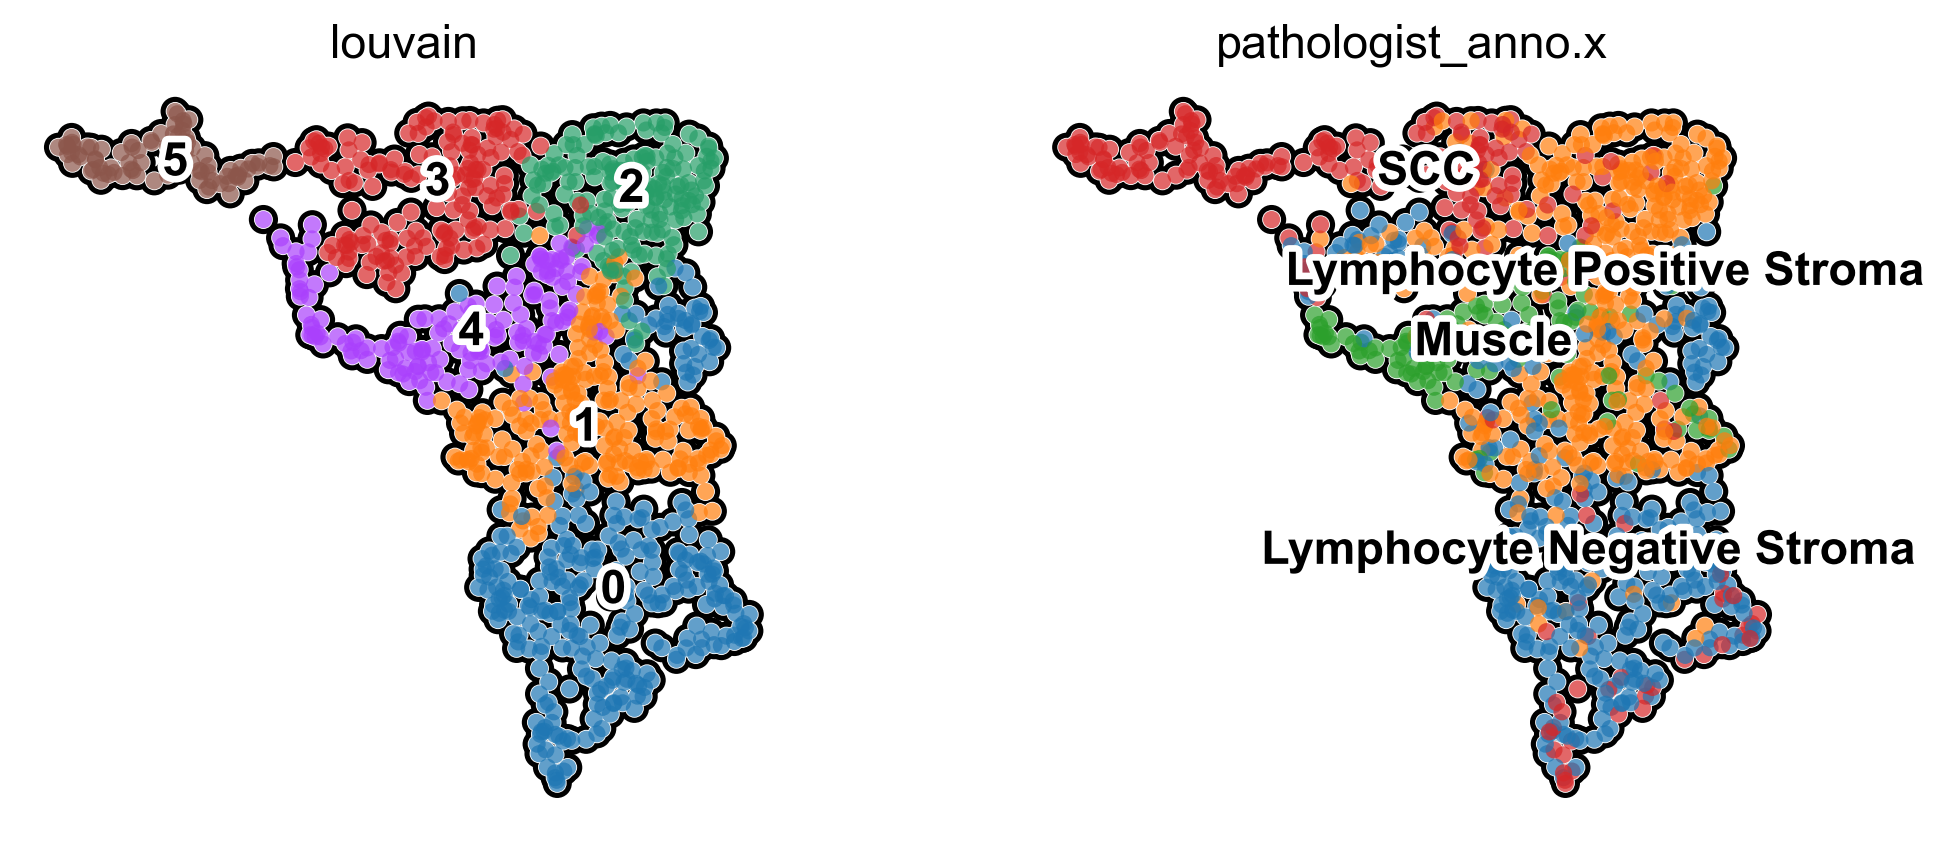

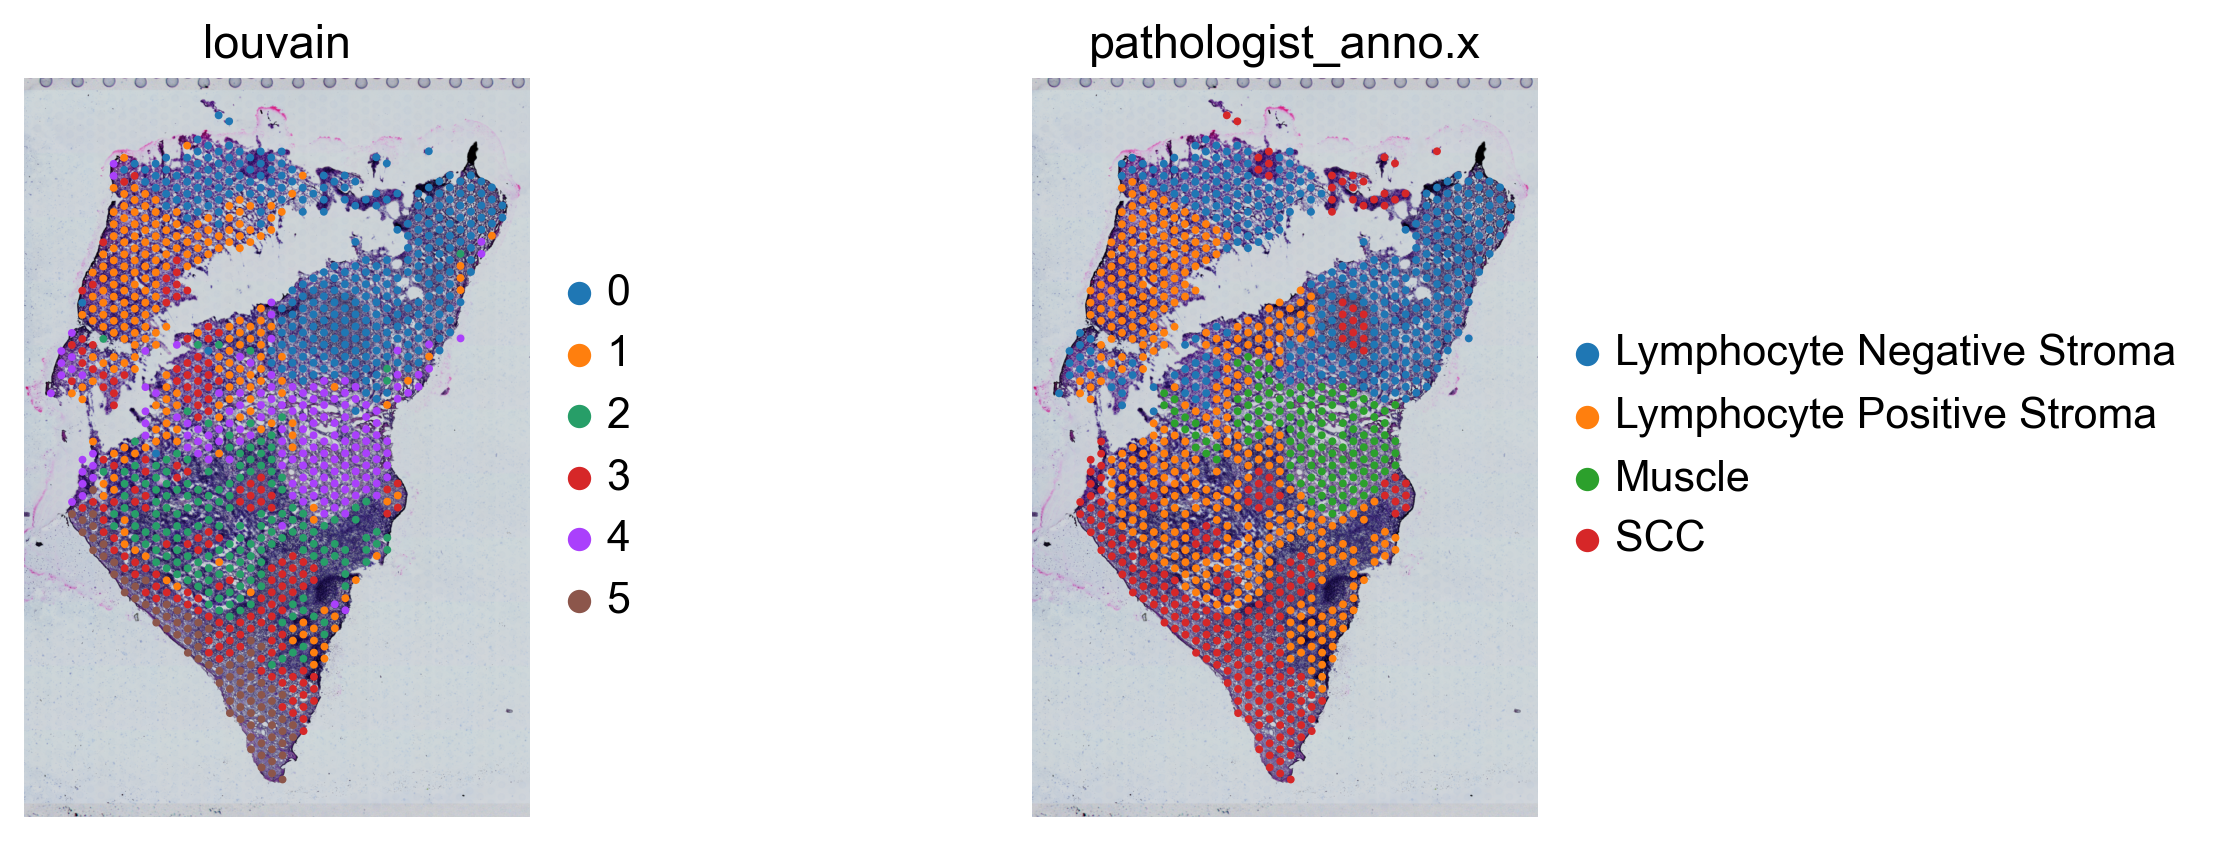

In [9]:
sc.pl.umap(adata, color=["louvain",'pathologist_anno.x'],
           legend_loc="on data", legend_fontoutline=4, add_outline=True, 
           frameon=False)
sc.pl.spatial(adata,color=["louvain","pathologist_anno.x"])

## Spatial domain enhancement

In [10]:
# UMAP for padded data
sc.pp.neighbors(adata_sp, use_rep="SP_TOPO")
sc.tl.umap(adata_sp)
# Propagate annotations
stfhelper.annotation_propagate(adata_sp, "louvain", adata, latent_embed="SP_TOPO")

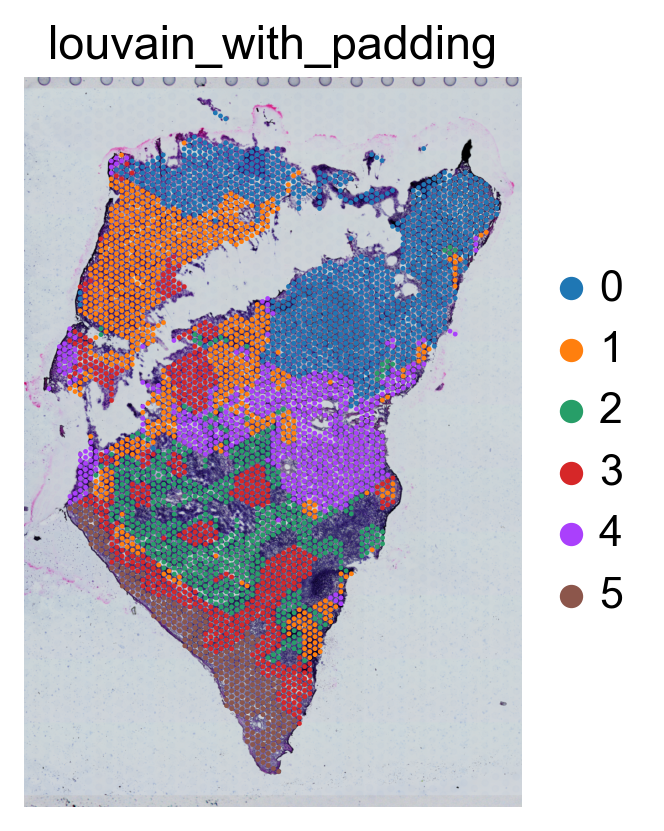

In [11]:
sc.pl.umap(adata_sp, color=["louvain_with_padding"], title="", legend_loc="on data", legend_fontoutline=4, add_outline=True, 
               frameon=False,
               save="_sp_pad_by_comb",)
sc.pl.spatial(adata_sp,color=['louvain_with_padding'],s=5, save="STForte_padding.pdf")

### Gene padding

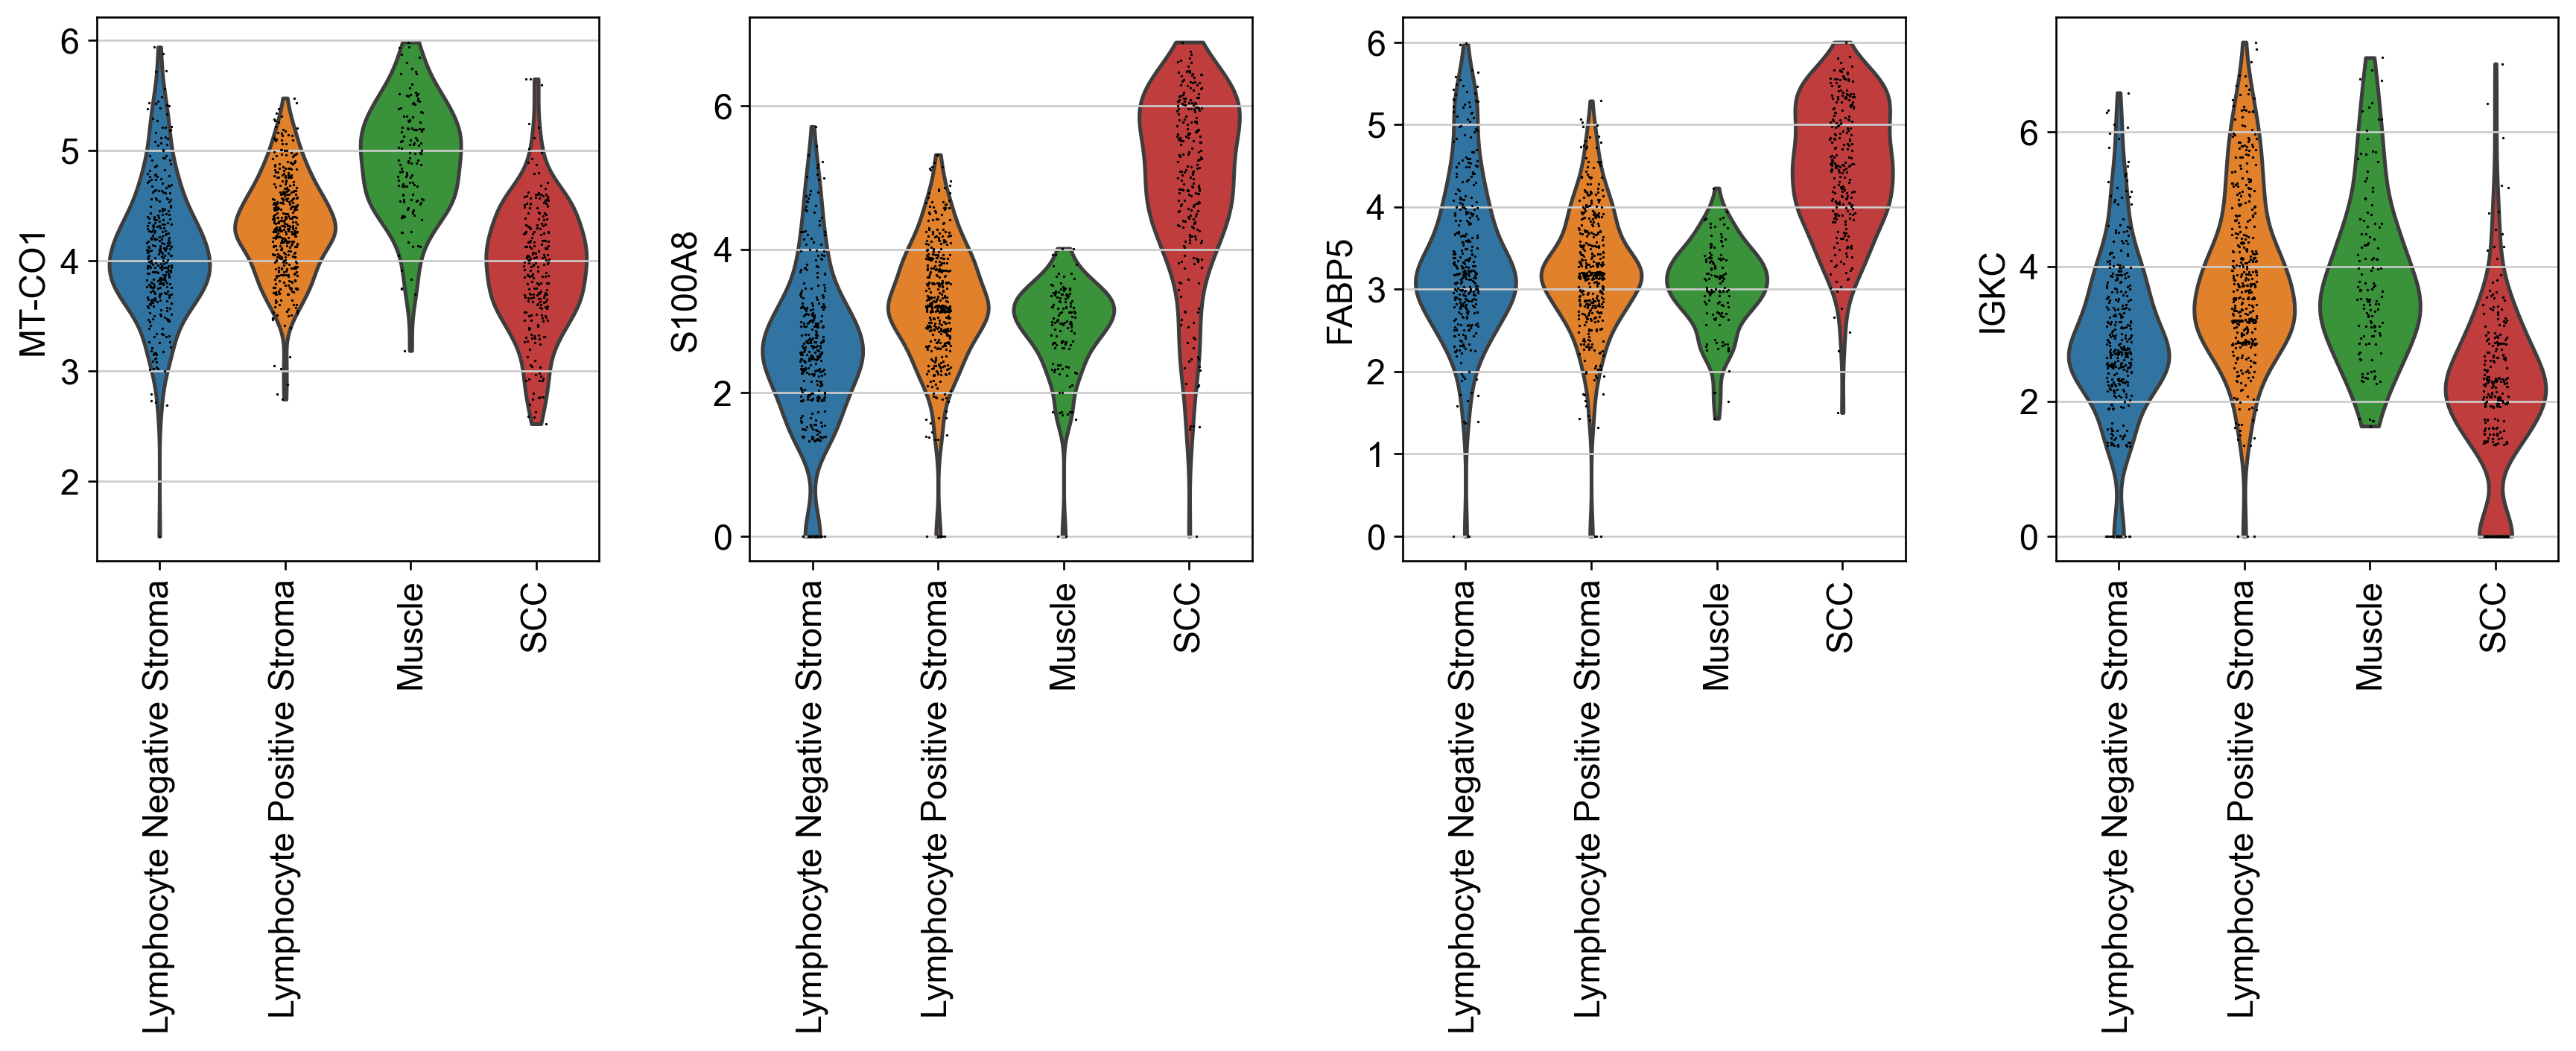

In [12]:
gene_names = ['MT-CO1','S100A8','FABP5','IGKC']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pl.violin(adata, keys=gene_names, groupby="pathologist_anno.x", xlabel="",  rotation=90)

In [13]:
sp_exp = stfhelper.complete_unseen_expression(adata_sp, gene_names, adata, 'SP_TOPO')

Propagating genes...:   0%|          | 0/4 [00:00<?, ?it/s]

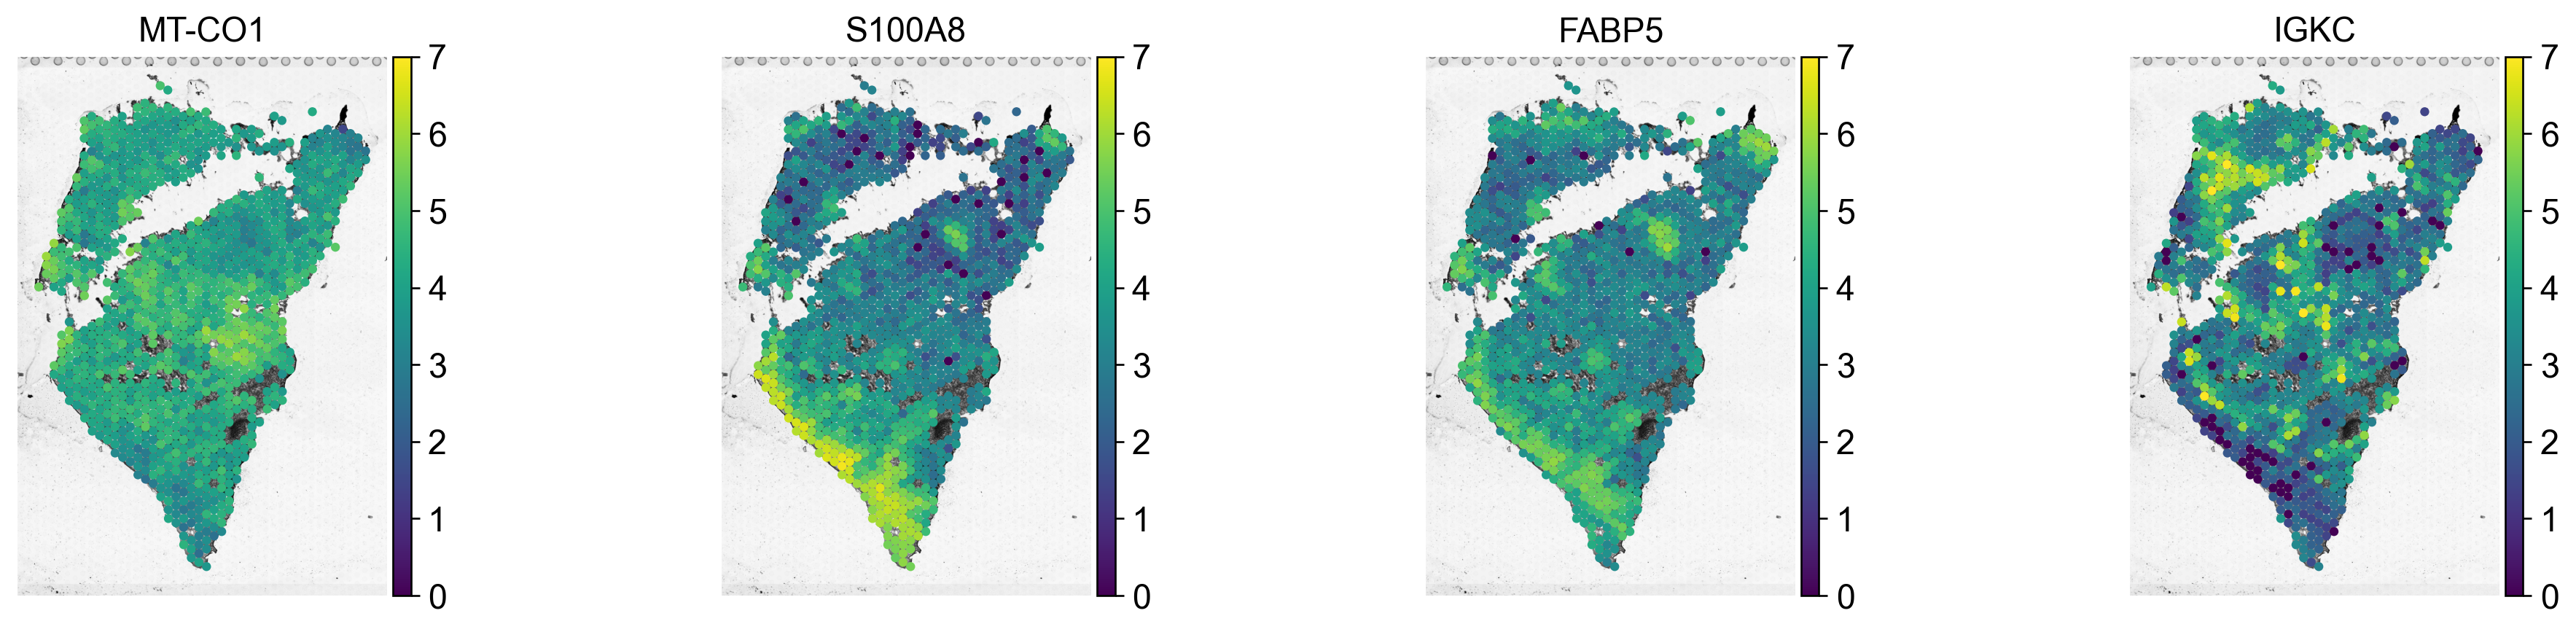

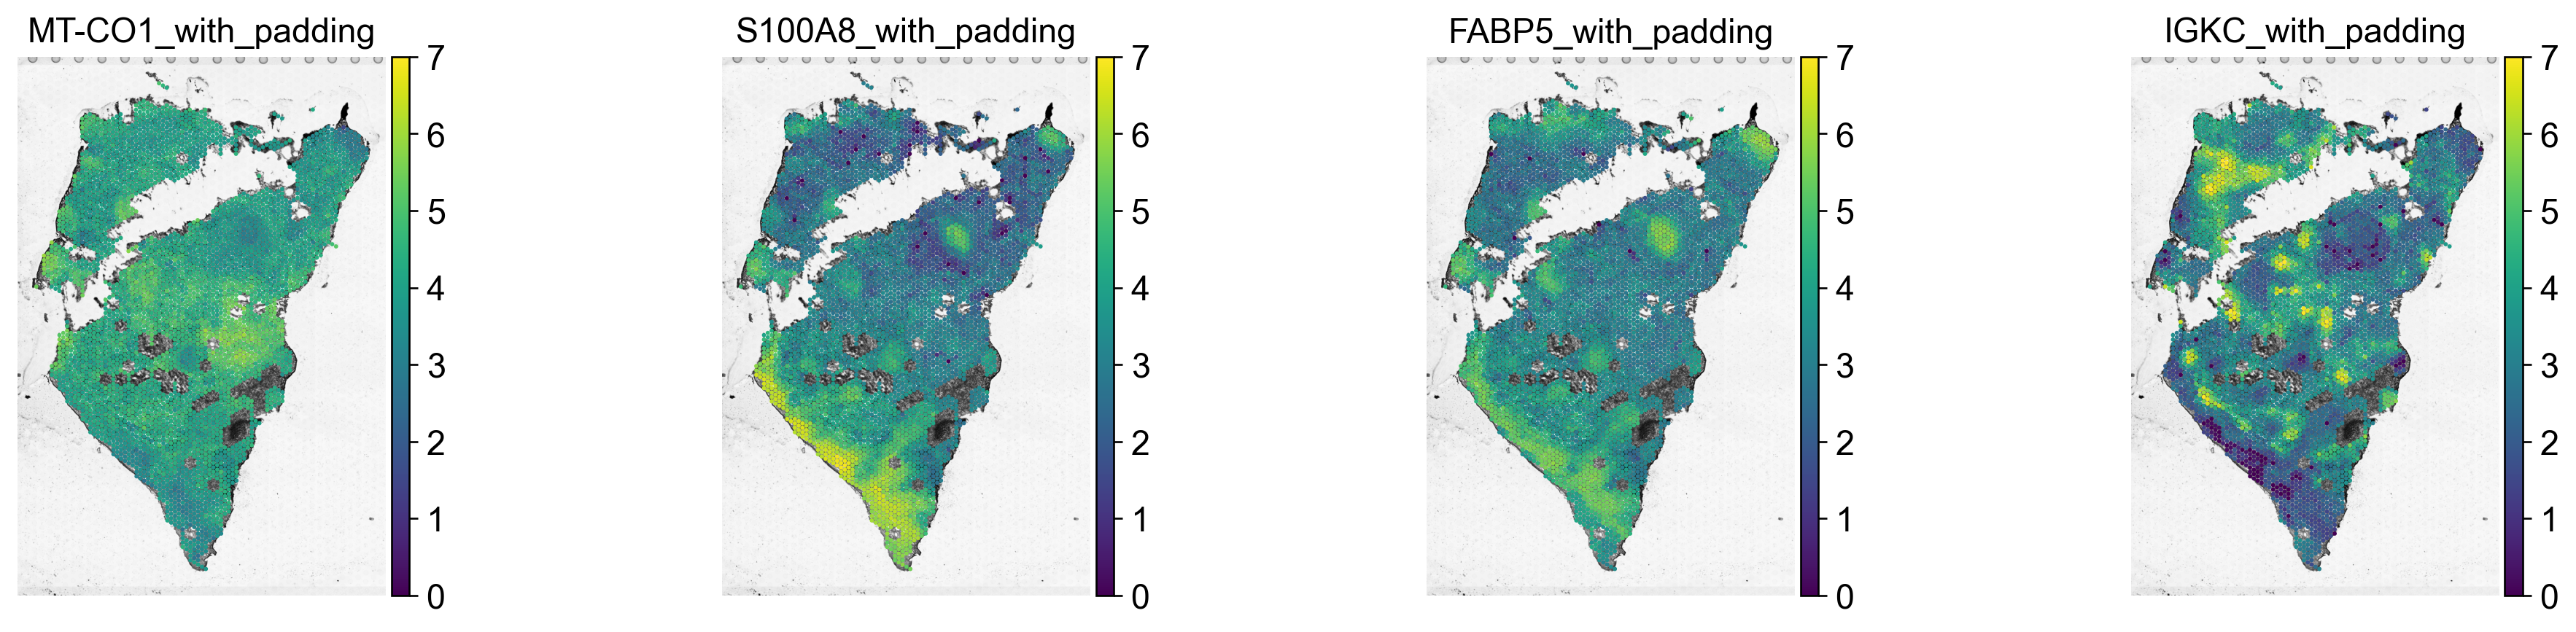

In [14]:
sc.pl.spatial(adata,color=gene_names,s=13, vmin=0,vmax=7, save="Gene_unpaded.pdf",bw=True)
sc.pl.spatial(adata_sp,color=[i + '_with_padding' for i in gene_names], s=6, vmin=0,vmax=7,save="Gene_STForte_padding.pdf",bw=True)